# Prerequisites

- Python 3.10.4

> Warning: Installation from conda environment may take few minutes

Configuring conda environment
```cmd
conda create -n ca2_env
conda activate ca2_env
conda install -c conda-forge pingouin
```

Installing jupyter notebook on ca2_env environment
```cmd
conda install jupyter notebook
python -m ipykernel install --name ca2_env
```

Run jupiter 
```cmd
jupyter notebook
```

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;
from scipy import stats 
import pingouin as pg

In [20]:
# Datasets
agriculture_df = pd.read_csv("../data/agriculture_dataset.csv")
ireland = agriculture_df.query("country == 'IE'")
eu_country_codes = pd.read_csv("../data/eu_country_codes.csv");
eu_country_codes.columns = ["id","description","iso2"]
eu_country_codes = eu_country_codes[["iso2","description"]].set_index("iso2")
country_codes_dic =  eu_country_codes.description.to_dict()

columns_dic = {
    #index
    "crop_production_idx":                        "Crops Production Index",
    "avg_import_idx":                             "Cereals Import Index",
    "avg_export_idx":                             "Cereals Export Index",
    "gross_value_added":                          "Gross Value Added (GVA)",
    # Crops and cerelas
    "crop_mean_residues_kg":                      "Crops Residues (Kg)",
    "crop_land_use_1000ha":                       "Crop land use x 1000ha",
    "cereals_produce_price_usd_tonne":            "Cereals Produce Price ($/tonne)",
    "total_subsides_on_field_crops":              "Subsides on Field Crops",
    "prod_cereals_real_price":                    "Cereals Value at Real Price",
    # Employment
    "employment_ratio_rural_areas_pct":           "% Employment Rural Areas",
    "female_employment_ratio_rural_areas_pct":    "% Female Employment Rural Areas",
    "male_employment_ratio_rural_areas_pct":      "% Male Employment Rural Areas",
    "mean_weekly_working_hours":                  "Avg. Work (hours/week) Rural Areas",
    "female_mean_weekly_working_hours":           "Avg. Female Work (hours/week) Rural Areas",
    "male_mean_weekly_working_hours":             "Avg. Male Work (hours/week) Rural Areas",
    # Agriculture
    "agri_energy_use_tj":                         "Agr. Energy use (Terajoule)",
    # Land
    "total_uaa_ha":                               "Total Utilised Agricultural Area (ha)",
    "pct_rented_land_of_uaa":                     "% Rented land of UAA",
    "rented_land_ha":                             "Rented UAA (ha)",
    "rent_paid":                                  "Rent paid (€)",
    # Salaries
    "compensation_of_employees":                  "Salary gross (pre-tax)",
    "wages_and_salaries":                         "Wages"
}

# Variable Analysis

In [21]:
ireland.shape

(17, 24)

In [22]:
 ireland.describe()

,year,crop_mean_residues_kg,crop_production_idx,cereals_produce_price_usd_tonne,employment_ratio_rural_areas_pct,female_employment_ratio_rural_areas_pct,male_employment_ratio_rural_areas_pct,mean_weekly_working_hours,female_mean_weekly_working_hours,male_mean_weekly_working_hours,...,avg_export_idx,total_subsides_on_field_crops,rented_land_ha,rent_paid,total_uaa_ha,pct_rented_land_of_uaa,gross_value_added,compensation_of_employees,wages_and_salaries,prod_cereals_real_price
count,17.000000,1.700000e+01,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,2012.000000,4.758808e+06,115.236633,183.519608,56.412941,48.940588,63.793824,50.147647,34.867059,52.392353,...,137.152941,1151.529412,25.093897,9851.291176,70.119971,35.350475,2252.505882,638.635294,524.435294,105.094706
std,5.049752,7.176535e+05,34.784519,47.713041,3.344534,2.261085,5.025201,1.626547,1.992880,1.357864,...,76.240459,3981.291328,7.733230,4253.233728,11.661572,5.448977,711.955944,76.506404,63.283182,28.633327
min,2004.000000,3.896111e+06,69.024767,126.666667,50.600000,45.210000,55.970000,48.060000,31.200000,50.570000,...,40.200000,0.000000,15.290000,5367.000000,52.730000,28.996776,946.500000,529.900000,432.500000,70.380000
25%,2008.000000,4.134453e+06,97.608000,148.500000,53.840000,47.210000,59.940000,49.330000,33.860000,51.680000,...,94.800000,28.000000,20.080000,6990.000000,60.950000,30.488009,1733.700000,595.400000,486.600000,89.780000
50%,2012.000000,4.711826e+06,104.182000,163.000000,56.760000,49.330000,63.280000,49.630000,34.880000,52.000000,...,114.800000,76.000000,22.060000,7603.000000,67.870000,34.778496,2070.000000,613.700000,510.400000,100.130000
75%,2016.000000,5.054516e+06,113.582000,208.333333,57.670000,50.110000,68.290000,50.470000,35.130000,52.880000,...,140.000000,383.000000,32.360000,14683.000000,81.200000,39.852217,2558.400000,685.700000,565.300000,112.030000
max,2020.000000,6.566029e+06,191.840000,276.333333,63.270000,53.120000,73.320000,54.090000,38.470000,55.740000,...,304.800000,16581.000000,39.180000,18255.000000,88.580000,44.231203,3501.900000,789.500000,649.500000,166.610000


In [23]:
# Gross Value Added
ireland.gross_value_added.describe()

count      17.000000
mean     2252.505882
std       711.955944
min       946.500000
25%      1733.700000
50%      2070.000000
75%      2558.400000
max      3501.900000
Name: gross_value_added, dtype: float64

In [24]:
ireland.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 221 to 237
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   country                                  17 non-null     object 
 1   year                                     17 non-null     int64  
 2   crop_mean_residues_kg                    17 non-null     float64
 3   crop_production_idx                      17 non-null     float64
 4   cereals_produce_price_usd_tonne          17 non-null     float64
 5   employment_ratio_rural_areas_pct         17 non-null     float64
 6   female_employment_ratio_rural_areas_pct  17 non-null     float64
 7   male_employment_ratio_rural_areas_pct    17 non-null     float64
 8   mean_weekly_working_hours                17 non-null     float64
 9   female_mean_weekly_working_hours         17 non-null     float64
 10  male_mean_weekly_working_hours           17 non-n

# Analysis of countries with similar characteristics to Ireland

Get countries that have similar GVA or Total Used Agricultural Area similar. 
- Criteria 1: Countries with GVA on 75% min and max range of Ireland mean GVA
- Criteria 2: Test Anova and post hoc analisys to identify countries

In [25]:
# Countries with simliar utilised agricultural area than IE
uaa_means = agriculture_df.groupby('country').total_uaa_ha.mean().reset_index()
gva_means = agriculture_df.groupby('country').gross_value_added.mean().reset_index()
ie_uua = uaa_means.query("country == 'IE'").total_uaa_ha.values[0]
ie_GVA = gva_means.query("country == 'IE'").gross_value_added.values[0]

country_with_similar_uaa = uaa_means.query(f"\
        total_uaa_ha >= {ie_uua * 0.25} and \
        total_uaa_ha <= {ie_uua * 1.75}").country.values.flatten()

counties_with_similar_gva = gva_means.query(f"\
        gross_value_added >= {ie_GVA * 0.25} and \
        gross_value_added <= {ie_GVA * 1.75} \
").country.values.flatten()

# Set similar countries to Ireland by UAA and GVA
similar_countries = list(set(country_with_similar_uaa).intersection(set(counties_with_similar_gva)))
similar_countries

['LT', 'PT', 'BE', 'IE', 'LV', 'DK']

## Criteria 2: Anova

### T-Test Assumptions

1. The first assumption made regarding t-tests concerns the scale of measurement. The assumption for a t-test is that the scale of measurement applied to the data collected follows a continuous or ordinal scale, such as the scores for an IQ test.

2. The second assumption made is that of a simple random sample, that the data is collected from a representative, randomly selected portion of the total population.

3. The third assumption is the data, when plotted, results in a normal distribution, bell-shaped distribution curve. When a normal distribution is assumed, one can specify a level of probability (alpha level, level of significance, p) as a criterion for acceptance. In most cases, a 5% value can be assumed.

4. The fourth assumption is a reasonably large sample size is used. A larger sample size means the distribution of results should approach a normal bell-shaped curve.


5. The final assumption is homogeneity of variance. Homogeneous, or equal, variance exists when the standard deviations of samples are approximately equal.

ref: Bartlett, M. S. (1937). Properties of sufficiency and statistical tests. Proc. R. Soc. Lond. A, 160(901), 268-282.

In [33]:
def plot_normal_dist(X: np.array, title="", save_to_file = ""):
    
    normallity_test_result = ""
    stat, pvalue = stats.shapiro(X)
    normallity_test_result = f"Shapiro-Wilk test pvalue: {pvalue}"
        
    
    fig = plt.figure(figsize=(10, 5), dpi=80)
    ax1 = fig.add_subplot(121)
    #X = dcc_geo_df.safety_index.to_numpy();
    mu, sigma = stats.norm.fit(X);

    # Plot the histogram.

    plt.hist(X, bins=10, density=True, alpha=0.6, color='b');

    # Normal Distribution: Plot the PDF.
    xmin, xmax = plt.xlim();
    x = np.linspace(xmin, xmax, 20);
    p = stats.norm.pdf(x, mu, sigma);

    if title != "":
        title = "{:}\nFit Values: mu {:.2f} and sigma {:.2f}".format(title, mu, sigma);
    else:
        title = "Fit Values: mu {:.2f} and sigma {:.2f}".format(mu, sigma);

    plt.plot(x, p, 'g', linewidth=2, label="Normal Distribution",)
    plt.title(title);

    ax2 = fig.add_subplot(122)
    stats.probplot(X, plot=ax2, dist=stats.norm)
    plt.title("Probability Plot for Normal\n{:}".format(normallity_test_result))

    if save_to_file != "":
        plt.savefig(save_to_file)
    plt.show()
    return pvalue

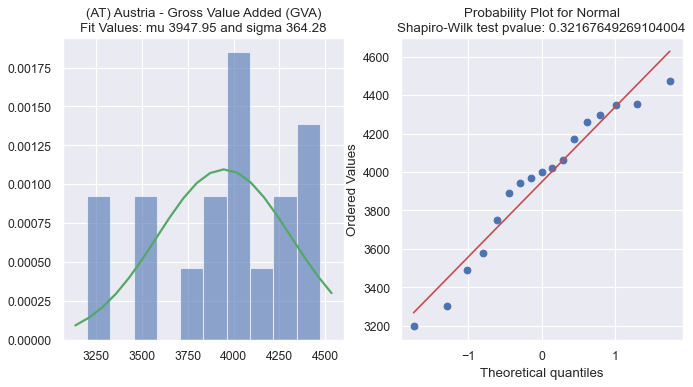

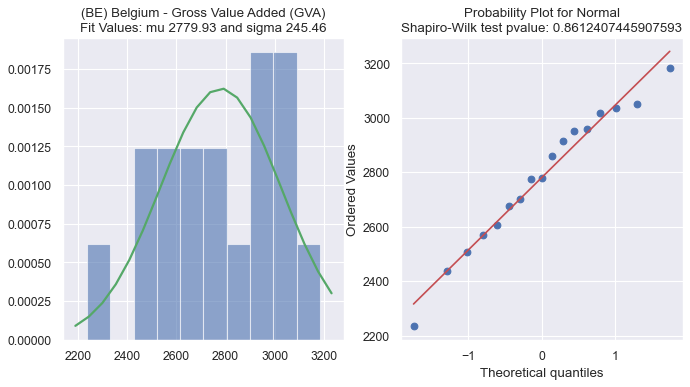

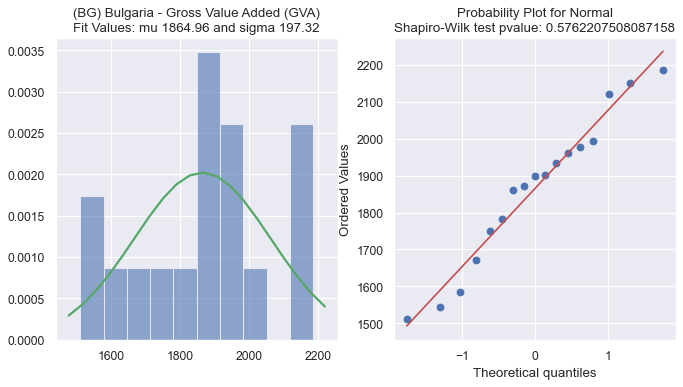

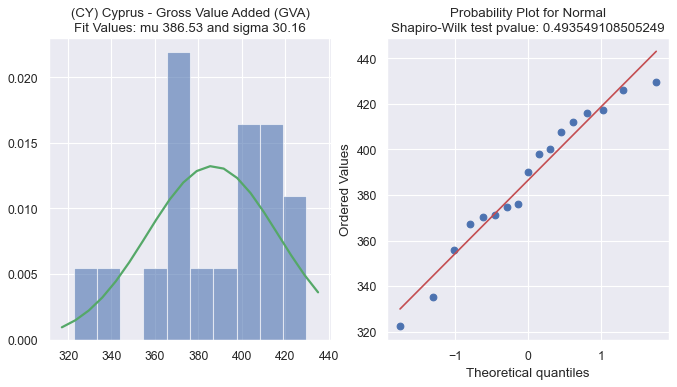

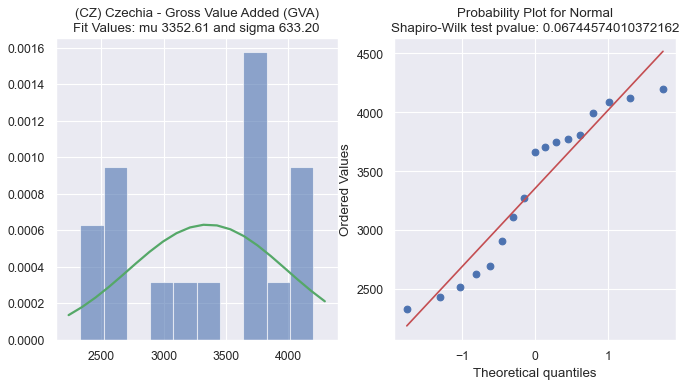

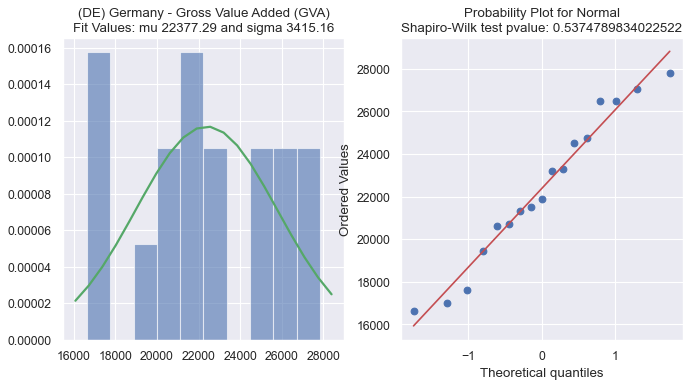

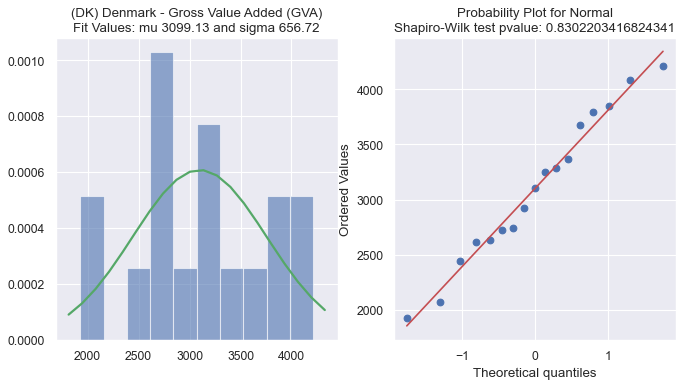

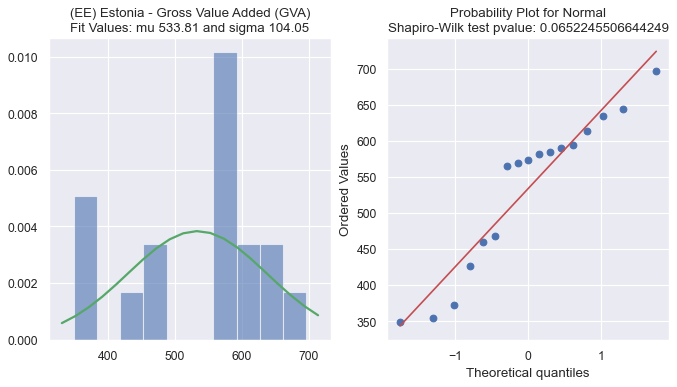

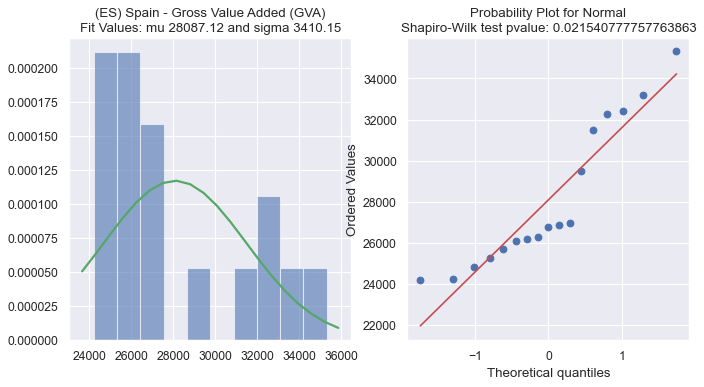

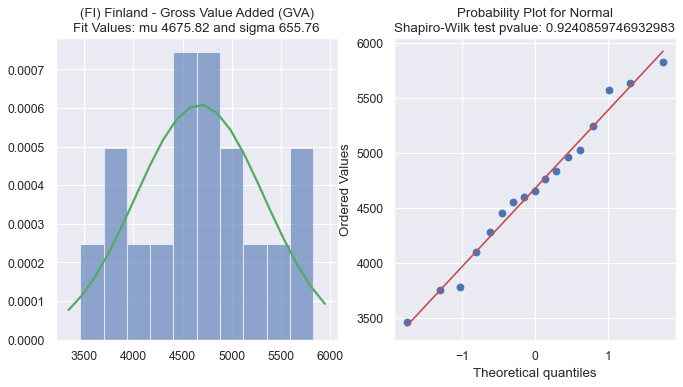

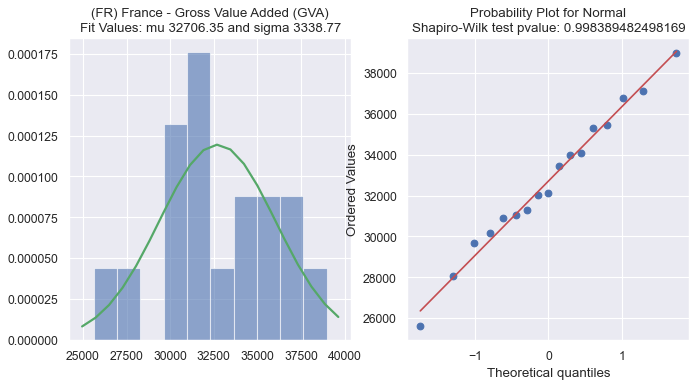

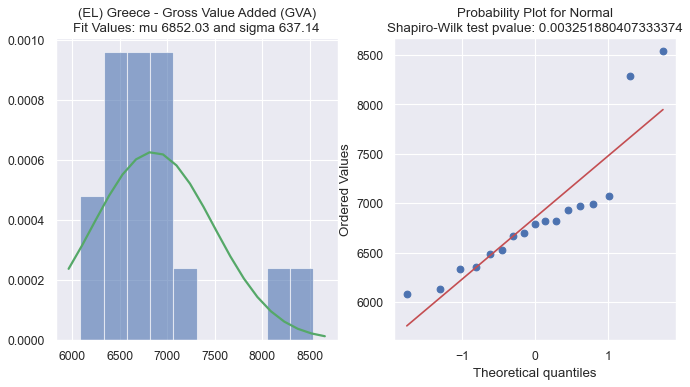

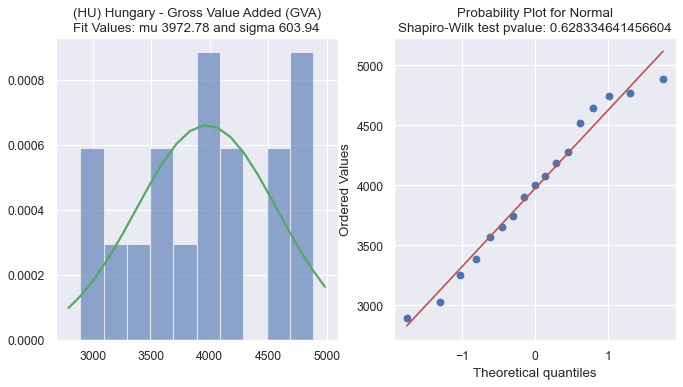

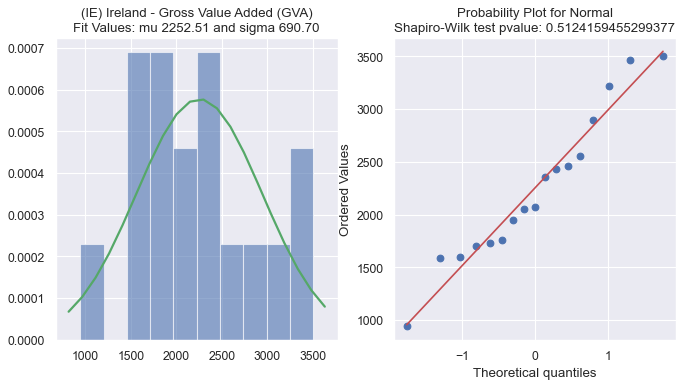

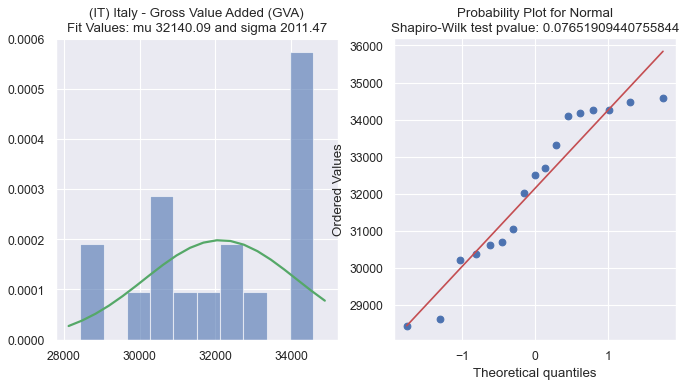

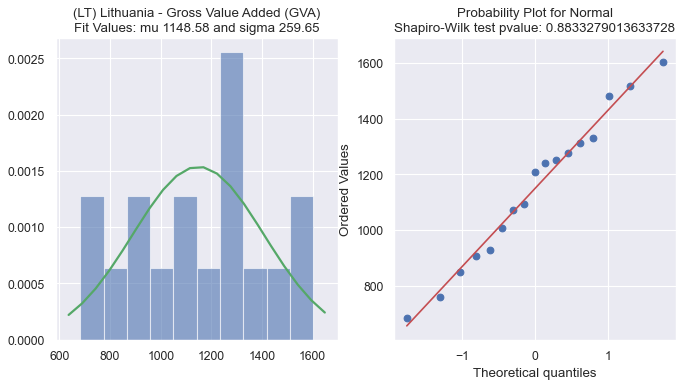

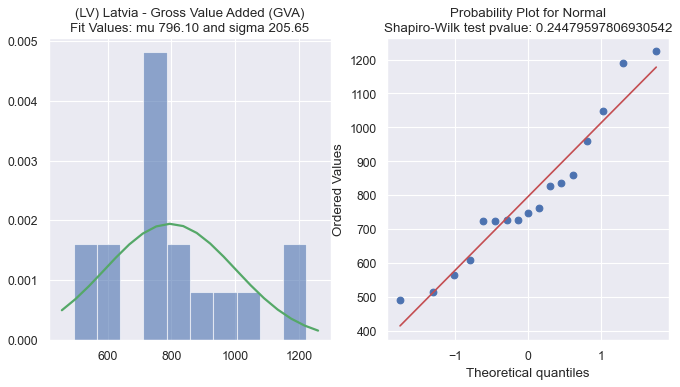

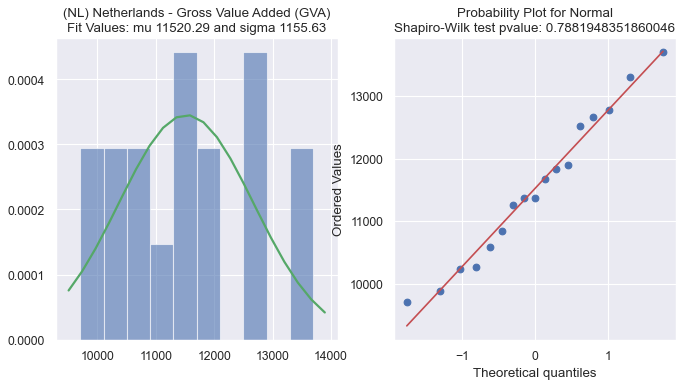

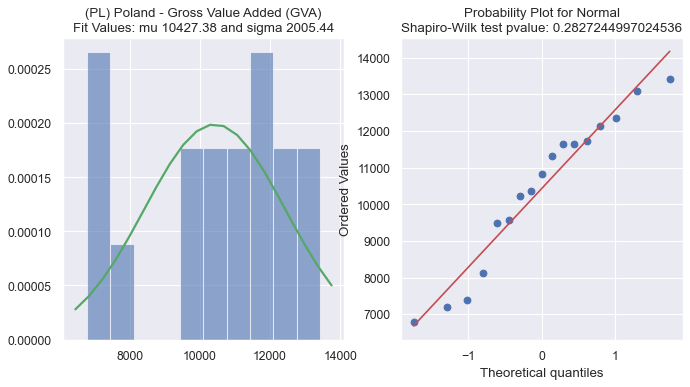

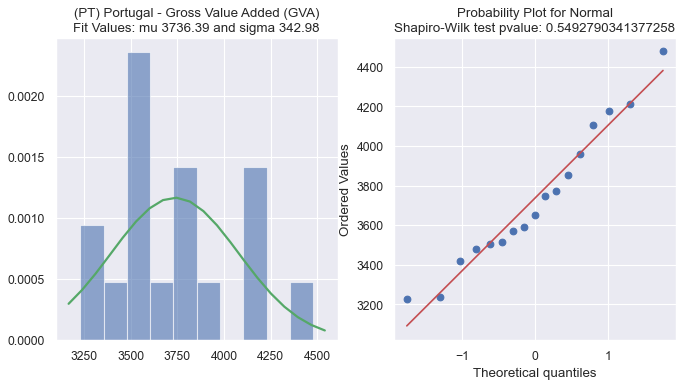

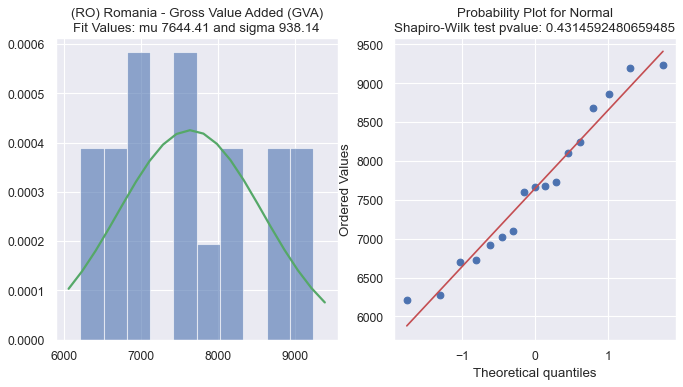

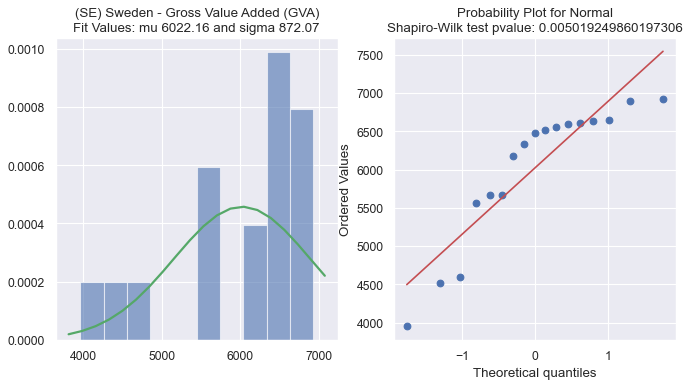

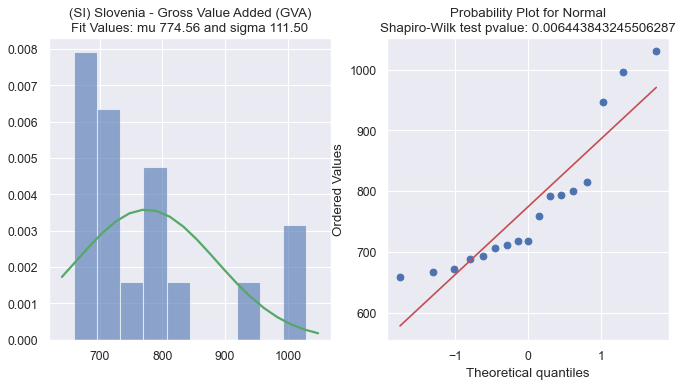

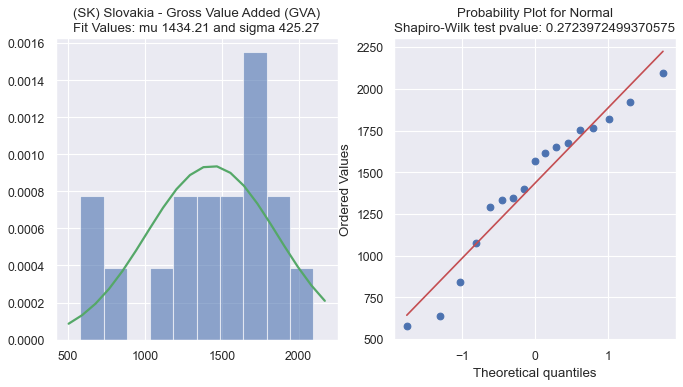

Analysing Homogeinity test Ireland / (AT) Austria
Analysing Homogeinity test Ireland / (BE) Belgium


NameError: name 'count' is not defined

In [34]:
# Check normal distribution on GVA for each country
variable = "gross_value_added"
gva_c_normal_dist = [[]]
for c in agriculture_df.country.unique():
    pvalue = plot_normal_dist(agriculture_df.query(f"country=='{c}'")[variable], 
                     f"{country_codes_dic.get(c)} - {columns_dic.get(variable)}", 
                     f"../visualizations/01_stats_normaldist_{variable}_{c}.png");
    if(pvalue > 0.05):
        if(gva_c_normal_dist[0] == []):
            gva_c_normal_dist[0] = [c,pvalue]
        else:
            gva_c_normal_dist.append([c,pvalue])
            
            
similar_countries = np.array(gva_c_normal_dist)[:,0]

#Homogeinity of variance between countries with Ireland for GVA: Levene's test
arr = [[]]
for c in similar_countries:
    if(c == 'IE'):
        continue;
        
    cName = country_codes_dic.get(c)
    print(f"Analysing Homogeinity test Ireland / {cName}")
    countries = ['IE', c]
    
    ds = agriculture_df.query("country in @countries")
    levenes_result = pg.homoscedasticity(ds, dv=variable, group='country', method='levene')
    if(arr[0] == []):
        arr[0] = list(np.append(levenes_result.values.flatten(),[variable, c]))
    else:
        arr.insert(count,list(np.append(levenes_result.values.flatten(),[variable, c])))
        
levene_df = pd.DataFrame(arr,columns=["W","pvalue","equal_var","variable","country"])       
levene_df.query("equal_var == True")

In [26]:
dataset = agriculture_df.query("country in @similar_countries")

<AxesSubplot:>

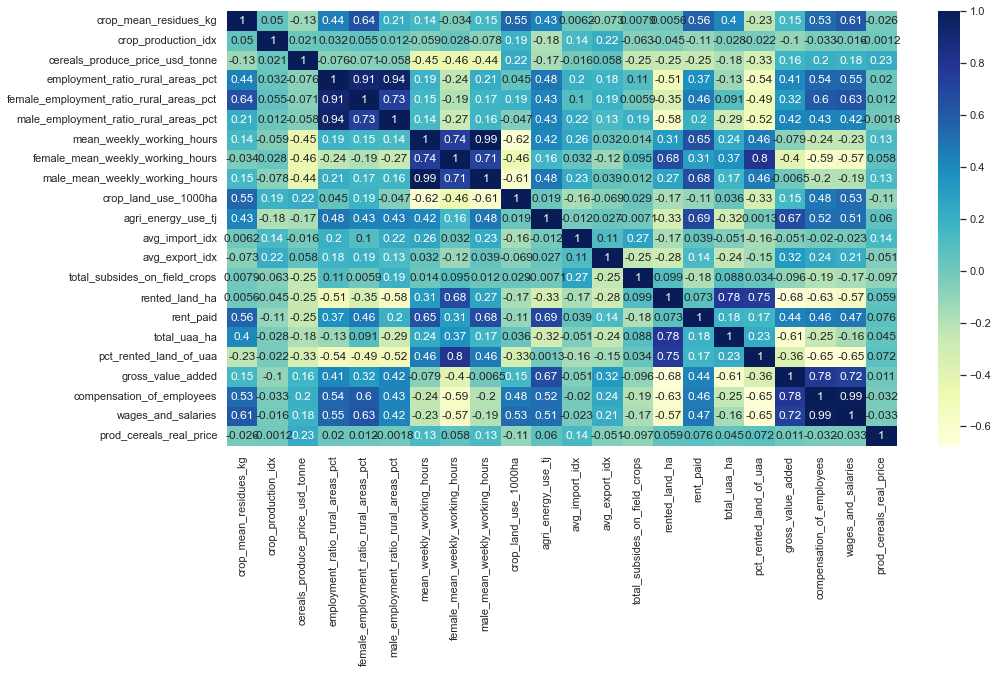

In [27]:
continuous_variables = ireland.dtypes[ireland.dtypes == np.float64].index
data = dataset[continuous_variables]
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

The criteria for selecting the above countries for the comparison analysis will be further investigating by comparing characteristics of them and analysis on the mean, variance and of the samples taken.

In [28]:
n = len(dataset.year.unique())
print(f"Sample data {n}")

Sample data 17


In [29]:
dataset.isna().sum().sort_index()

agri_energy_use_tj                         0
avg_export_idx                             0
avg_import_idx                             0
cereals_produce_price_usd_tonne            0
compensation_of_employees                  0
country                                    0
crop_land_use_1000ha                       0
crop_mean_residues_kg                      0
crop_production_idx                        0
employment_ratio_rural_areas_pct           0
female_employment_ratio_rural_areas_pct    0
female_mean_weekly_working_hours           0
gross_value_added                          0
male_employment_ratio_rural_areas_pct      0
male_mean_weekly_working_hours             0
mean_weekly_working_hours                  0
pct_rented_land_of_uaa                     0
prod_cereals_real_price                    0
rent_paid                                  0
rented_land_ha                             0
total_subsides_on_field_crops              0
total_uaa_ha                               0
wages_and_

## T-Test Assumptions

1. The first assumption made regarding t-tests concerns the scale of measurement. The assumption for a t-test is that the scale of measurement applied to the data collected follows a continuous or ordinal scale, such as the scores for an IQ test.

2. The second assumption made is that of a simple random sample, that the data is collected from a representative, randomly selected portion of the total population.

3. The third assumption is the data, when plotted, results in a normal distribution, bell-shaped distribution curve. When a normal distribution is assumed, one can specify a level of probability (alpha level, level of significance, p) as a criterion for acceptance. In most cases, a 5% value can be assumed.

4. The fourth assumption is a reasonably large sample size is used. A larger sample size means the distribution of results should approach a normal bell-shaped curve.

5. The final assumption is homogeneity of variance. Homogeneous, or equal, variance exists when the standard deviations of samples are approximately equal.

## 1. Ireland 

In [30]:
def plot_normal_dist(X: np.array, title="", save_to_file = ""):
    fig = plt.figure(figsize=(10, 5), dpi=80)
    ax1 = fig.add_subplot(121)
    #X = dcc_geo_df.safety_index.to_numpy();
    mu, sigma = stats.norm.fit(X);

    # Plot the histogram.

    plt.hist(X, bins=8, density=True, alpha=0.6, color='b');

    # Normal Distribution: Plot the PDF.
    xmin, xmax = plt.xlim();
    x = np.linspace(xmin, xmax, 20);
    p = stats.norm.pdf(x, mu, sigma);

    if title != "":
        title = "{:}\nFit Values: mu {:.2f} and sigma {:.2f}".format(title, mu, sigma);
    else:
        title = "Fit Values: mu {:.2f} and sigma {:.2f}".format(mu, sigma);

    plt.plot(x, p, 'g', linewidth=2, label="Normal Distribution",)
    plt.title(title);

    ax2 = fig.add_subplot(122)
    stats.probplot(X, plot=ax2, dist=stats.norm)
    plt.title("Probability Plot for Normal")

    if save_to_file != "":
        plt.savefig(save_to_file)
    plt.show()

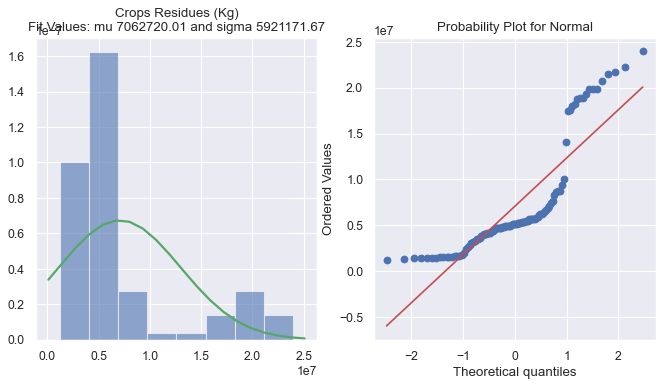

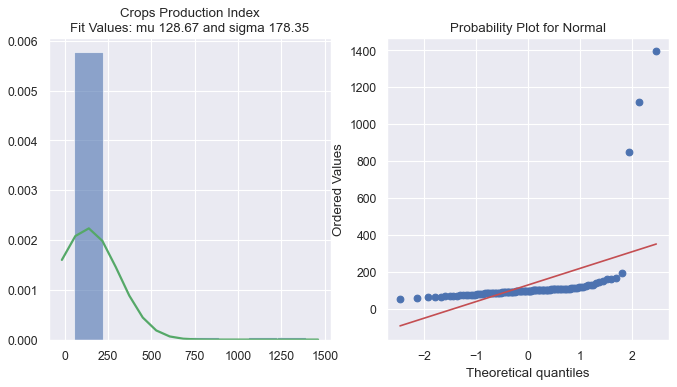

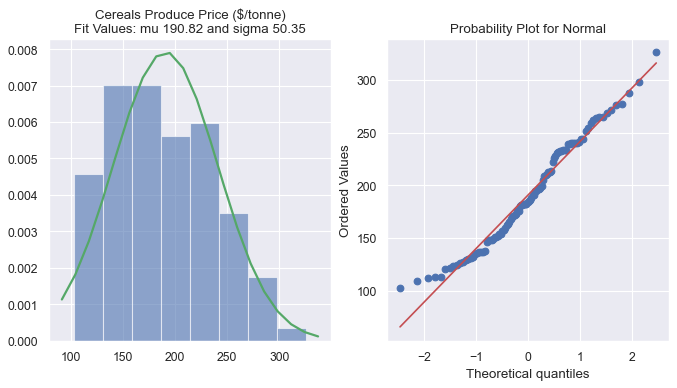

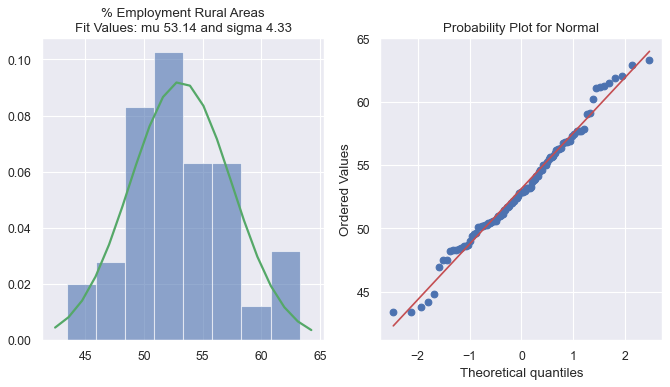

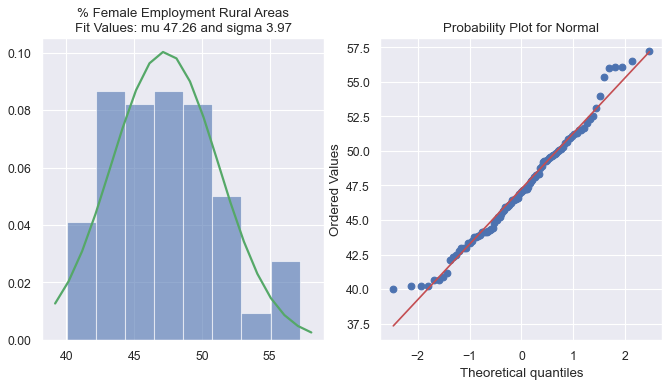

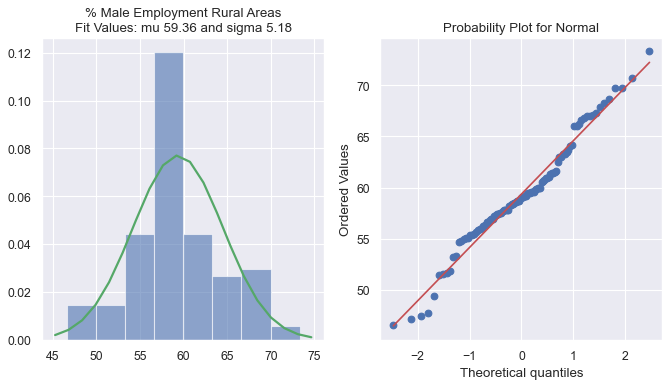

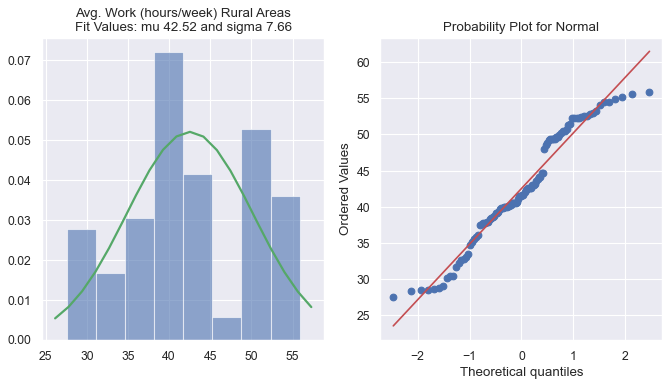

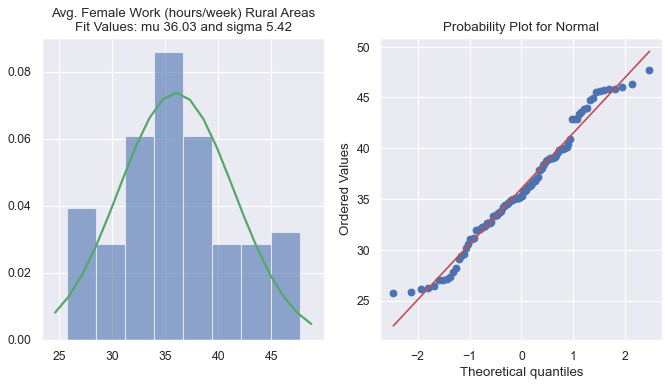

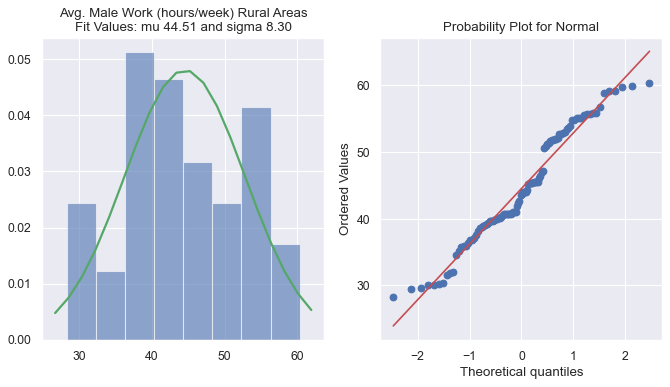

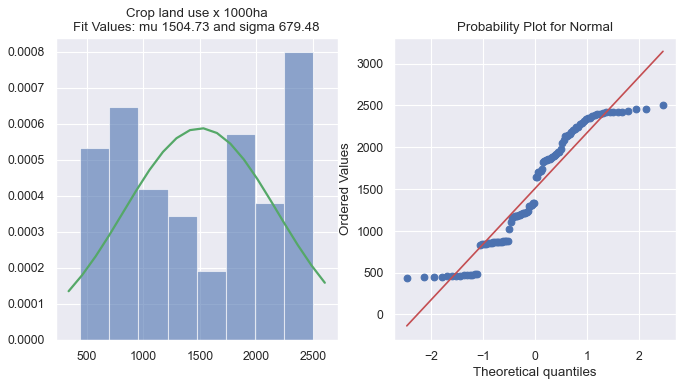

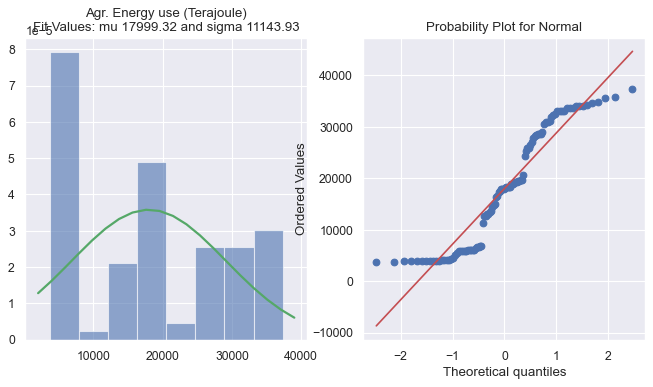

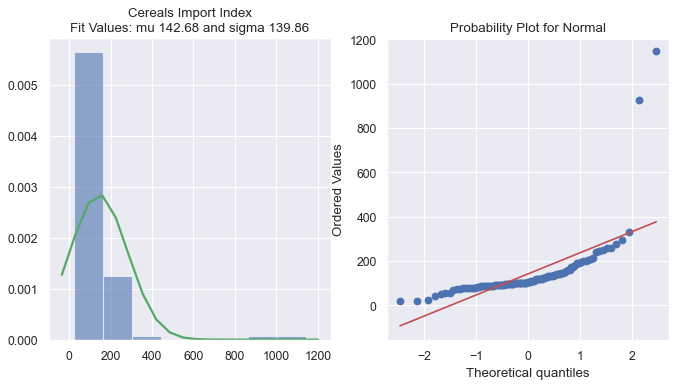

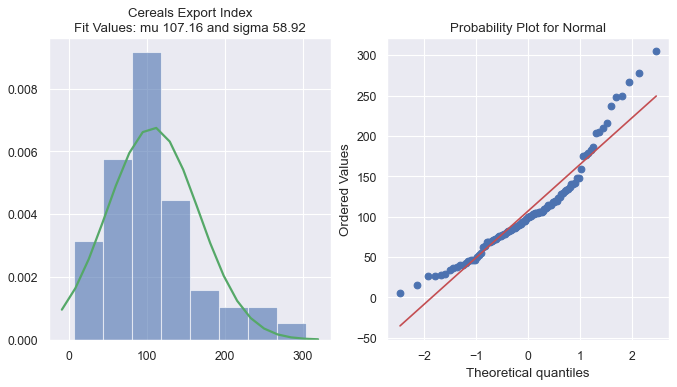

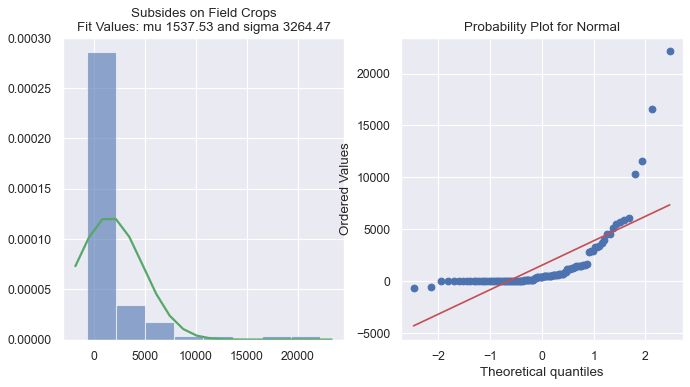

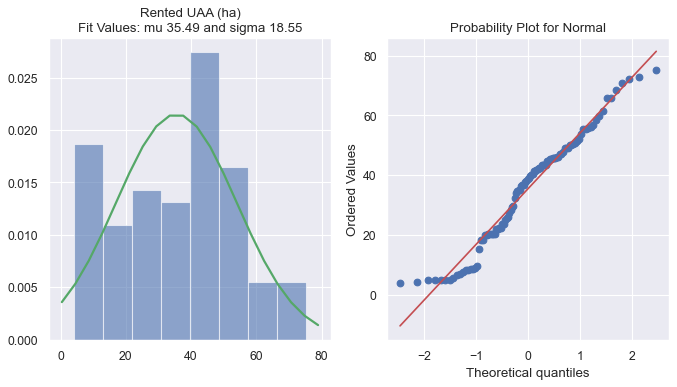

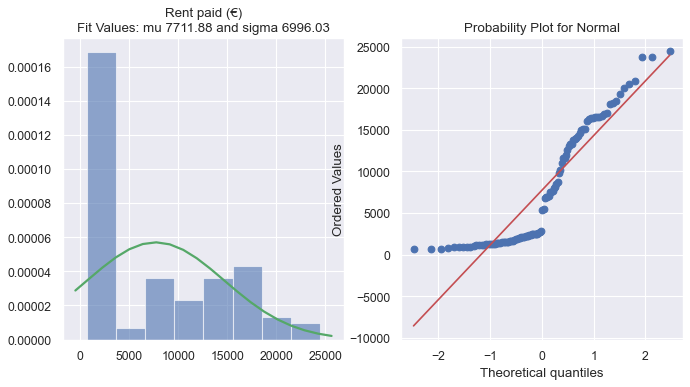

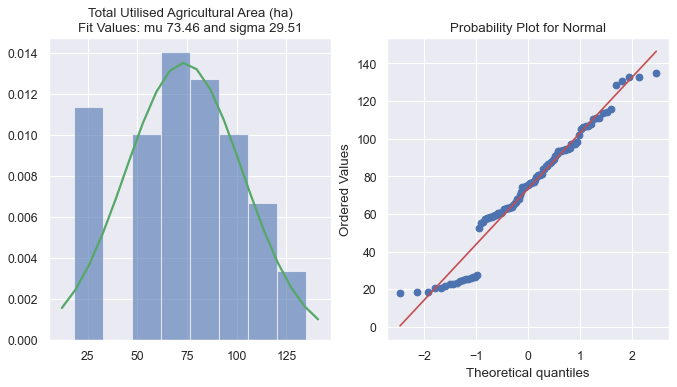

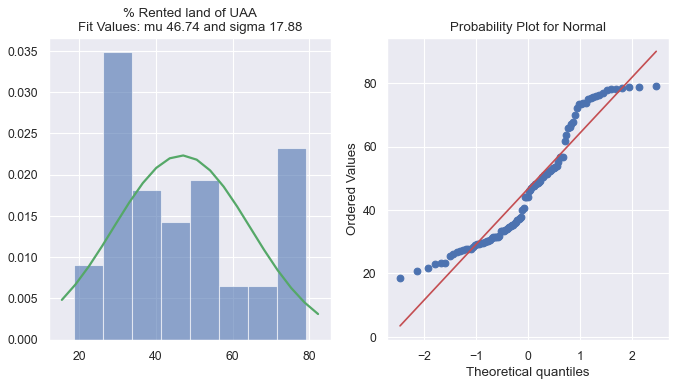

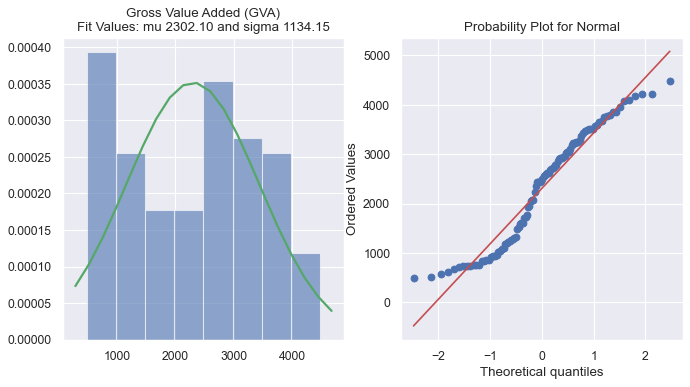

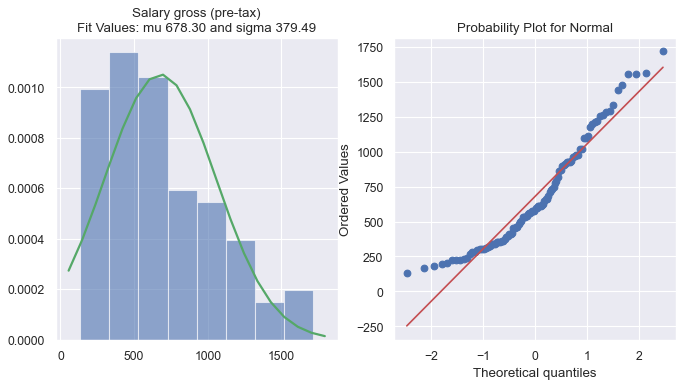

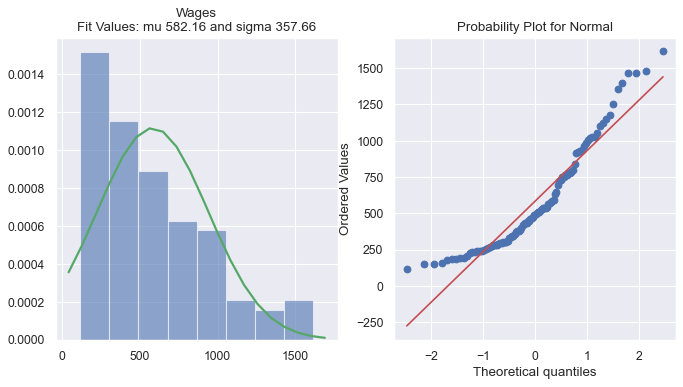

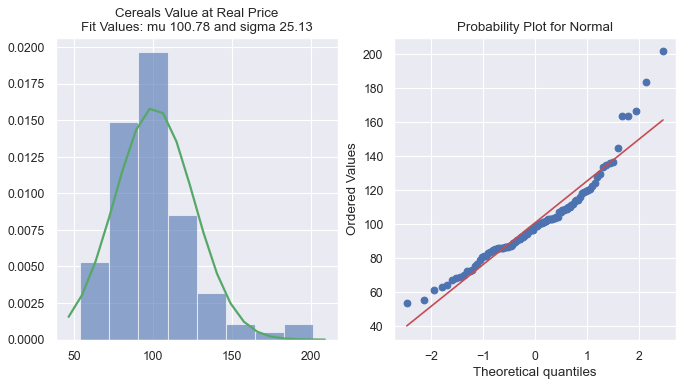

In [31]:
# Normal distribution check
for variable in continuous_variables:
    plot_normal_dist(dataset[variable], 
                     columns_dic.get(variable) , 
                     f"../visualizations/01_stats_{variable}_normaldist.png")

The following variables shows approximately Normal distribution as per fit to histogram plot and regarding probability Plot: The below variables data points plots looks fairly straight, indicating normality.

    - "avg_export_idx"
    - "avg_import_idx" # (2 outliers)
    - "cereals_produce_price_usd_tonne"
    - "compensation_of_employees"
    - "crop_land_use_1000ha"
    - "employment_ratio_rural_areas_pct"
    - "female_employment_ratio_rural_areas_pct"
    - "male_employment_ratio_rural_areas_pct"
    - "gross_value_added"
    - "mean_weekly_working_hours"
    - "prod_cereals_real_price"
    - "rented_land_ha"
    - "total_uaa_ha"
    - "wages_and_salaries"


In [ ]:
variables_normally_dist_candidates = [
    "cereals_produce_price_usd_tonne",
    "compensation_of_employees",
    "crop_land_use_1000ha",
    "employment_ratio_rural_areas_pct",
    "female_employment_ratio_rural_areas_pct",
    "male_employment_ratio_rural_areas_pct",
    "gross_value_added",
    "mean_weekly_working_hours",
    "prod_cereals_real_price",
    "rented_land_ha",
    "total_uaa_ha",
    "wages_and_salaries"
]

In [ ]:
# Shapiro wilk test for normality in Irish dataset
variables_normally_dist = []
for variable in variables_normally_dist_candidates:
    stat, pvalue = stats.shapiro(ireland[variable])
    result = ""
    if(pvalue > 0.05):
        variables_normally_dist.append(variable)
    else:
        print(f"Removing {variable} with pvalue: {pvalue}")
    


In [ ]:
variables_normally_dist

## Check homogeneity of variances for each series of data

In [ ]:
#Homogeinity of variance: Levene's test
arr = [[]]
count = 0 
for variable in variables_normally_dist:
    levenes_result = pg.homoscedasticity(dataset, dv=variable, group='country',method='levene')
    if(count == 0):
        arr[0] = list(np.append(levenes_result.values.flatten(),[variable, "all"]))
    else:
        arr.insert(count,list(np.append(levenes_result.values.flatten(),[variable, "all"])))
    
    count+=1

levene_df = pd.DataFrame(arr,columns=["W","pvalue","equal_var","variable","country"])       
levene_df.query("equal_var == True")
    

## Check homogeneity of variances within others countries on selected variables

In [ ]:
levene_df.query("equal_var == True").variable

for c in similar_countries:
    if(c == 'IE'):
        continue;
    cName = eu_country_codes.query(f"ISO2 == '{c}'")["Member State"].values[0]
    print(f"Analysing Homogeinity test Ireland / {cName}")
    countries = ['IE', c]
    count = 0
    arr = [[]]
    for variable in levene_df.query("equal_var == True").variable.unique():
        ds = dataset.query("country in @countries")
        levenes_result = pg.homoscedasticity(ds, dv=variable, group='country', method='levene')
        if(count == 0):
            arr[0] = list(np.append(levenes_result.values.flatten(),[variable, c]))
        else:
            arr.insert(count,list(np.append(levenes_result.values.flatten(),[variable, c])))
        count += 1
    levene_df = pd.concat([levene_df, pd.DataFrame(arr,columns=["W","pvalue","equal_var","variable","country"])])

In [ ]:
levene_df.query("equal_var == True")

In [ ]:
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import statsmodels.api as sm

# One-way ANOVA 
## Employment ratio rural areas for countries has no differences amongs the means

- H0: $mu_1 = mu_2 = mu_3$
- H1: At least 1 difference on the means
- alpha = `0.05`
- Degress of freedom between (k - 1): 6 countries = `5`
- Degress of freedom within N - k: 17 - 6 = `11`

In [ ]:
dataset

In [ ]:

IE = dataset.query("country == 'IE'").employment_ratio_rural_areas_pct
DK = dataset.query("country == 'DK'").employment_ratio_rural_areas_pct
LV = dataset.query("country == 'LV'").employment_ratio_rural_areas_pct
LT = dataset.query("country == 'LT'").employment_ratio_rural_areas_pct
BE = dataset.query("country == 'BE'").employment_ratio_rural_areas_pct
PT = dataset.query("country == 'PT'").employment_ratio_rural_areas_pct
  
# Conduct the one-way ANOVA within the groups
stat, pvalue = f_oneway(IE, DK, LV, LT,BE, PT)
if(pvalue > 0.05):
    print("Medians are equal")
else:
    print(f"At least one mean is different with {pvalue}")

In [ ]:
model = ols('employment_ratio_rural_areas_pct~country', data = dataset).fit()
aov2 = sm.stats.anova_lm(model, type=2)
print(aov2)

In [ ]:
### Post hoc for the 6 countries
comp = mc.MultiComparison(dataset['employment_ratio_rural_areas_pct'], dataset['country'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

## Employment by gender analysis

In [ ]:
dataset[['female_employment_ratio_rural_areas_pct','male_employment_ratio_rural_areas_pct']].corr(method='pearson')

In [ ]:
# Check means of the 2 groups male and female.
dataset[['female_employment_ratio_rural_areas_pct','male_employment_ratio_rural_areas_pct']].describe()

In [ ]:
dataset

In [ ]:
stat, pvalue = stats.levene(dataset.female_employment_ratio_rural_areas_pct, dataset.male_employment_ratio_rural_areas_pct)
print(f"H1: There is homegeneity of variance in male and female employment ratio with levene test pvalue {pvalue}")

> BoxPlot employment ratio by gender 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_gender = dataset[['female_employment_ratio_rural_areas_pct','male_employment_ratio_rural_areas_pct']]
df_gender.columns = ["Female","Male"]
df_melt = df_gender.melt()

# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments

ax = sns.boxplot(x='variable', y='value', data=df_melt, color='#99c2a2')
ax = sns.swarmplot(x="variable", y="value", data=df_melt, color='#7d0013')
plt.show()